In [1]:
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    AutoTokenizer,
)
import torch
import os
import ast
import re

/scratch/cluster/piti/miniconda/envs/loading_models/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### hyperparameters

In [11]:
N_SAMPLES = 10 # no.of samples/trajectories
K = 9 #no. of vines for each sample to estimate MC return per token

In [4]:
model_output_dir = "aug_10_x_lr"

model_eval_dir = "aug_10_x_lr/eval_df"
eval_files = [f for f in os.listdir(model_eval_dir) if f.startswith("eval_df_") and f.endswith(".csv")]
eval_files.sort()

In [5]:
base_policy_id = "cleanrl/EleutherAI_pythia-1b-deduped__sft__tldr" 
reward_model_id = "cleanrl/EleutherAI_pythia-1b-deduped__reward__tldr"
trained_value_model_id = "Prathyusha101/aug_10_x_lr" 

In [7]:
reward_model = AutoModelForSequenceClassification.from_pretrained(reward_model_id)
trained_value_model = AutoModelForSequenceClassification.from_pretrained(trained_value_model_id)
policy = AutoModelForCausalLM.from_pretrained(base_policy_id)
tokenizer = AutoTokenizer.from_pretrained(base_policy_id)

### cuda stuff, setting device and loading models to gpu

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model.to(device)
trained_value_model.to(device)
policy.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-15): 16 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (final_layer_norm): LayerNorm((2048,), eps=1e-05, 

### loading eval_files df with different pred_value_per_token columns from each point

In [9]:
def parse_tensor_string(tensor_str: str):
    # Remove leading/trailing whitespace and newline characters
    tensor_str = tensor_str.strip()
    if tensor_str.startswith("tensor(") and tensor_str.endswith(")"):
        inner = tensor_str[len("tensor("):-1]
        return torch.tensor(ast.literal_eval(inner))
    else:
        raise ValueError(f"Invalid tensor format: {tensor_str[:50]}...")


In [12]:
base_df = None
pred_dfs = []

for file in eval_files:
    checkpoint = file.split("_")[-1].replace(".csv", "")
    df = pd.read_csv(os.path.join(model_eval_dir, file))

    # Parse pred_value_per_token: from '[[...]]' to list of floats
    df["parsed_pred"] = df["pred_value_per_token"].apply(lambda x: ast.literal_eval(x)[0])

    # Parse prompt_ids and response_ids
    df["prompt_ids"] = df["prompt_ids"].apply(parse_tensor_string)
    df["response_ids"] = df["response_ids"].apply(parse_tensor_string)

    # Save shared columns once
    if base_df is None:
        base_df = df.drop(columns=["pred_value_per_token", "parsed_pred"])

    # Rename and store prediction list column
    pred_col = df[["parsed_pred"]].copy()
    pred_col.rename(columns={"parsed_pred": f"pred_value_per_token_{checkpoint}"}, inplace=True)
    pred_dfs.append(pred_col)

# Combine base with parsed predictions
eval_df = pd.concat([base_df] + pred_dfs, axis=1)

In [13]:
eval_df

,Unnamed: 0,prompt_token_len,response_token_len,prompt_ids,response_ids,prompt,response,pred_value_per_token_0,pred_value_per_token_1,pred_value_per_token_2,pred_value_per_token_3,pred_value_per_token_4,pred_value_per_token_5,pred_value_per_token_6,pred_value_per_token_7,pred_value_per_token_8,pred_value_per_token_9
0,0,503,36,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(3220), tensor(346), tensor(8471), tens...",SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,"My ""friend"" and I were just hanging out, and i...","[-0.05712890625, -0.0537109375, -0.0556640625,...","[0.34765625, 0.40234375, -0.609375, -0.1884765...","[-0.0206298828125, 0.50390625, 0.33203125, 0.3...","[-0.5625, -0.376953125, -0.474609375, -0.48242...","[-0.609375, -0.1962890625, -0.69140625, -0.304...","[-0.158203125, 0.1591796875, -0.1552734375, 0....","[-0.353515625, -0.07861328125, -0.69921875, -0...","[0.10546875, 0.70703125, -0.203125, 0.13964843...","[0.494140625, 0.58203125, 0.0791015625, 0.0810...","[-0.2080078125, -0.01214599609375, -0.38671875..."
1,1,283,25,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(3220), tensor(6858), tensor(16), tenso...",SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,My baby/boyfriend dies suddenly and his family...,"[-0.03857421875, -0.0361328125, -0.04174804687...","[0.9609375, 1.0625, 1.0625, 1.125, 1.203125, 1...","[-0.2177734375, 0.08056640625, 0.134765625, 0....","[0.031982421875, 0.1279296875, 0.1396484375, 0...","[0.609375, 0.80859375, 0.4296875, 0.640625, 1....","[0.5078125, 0.73046875, 0.66796875, 0.73828125...","[0.263671875, 0.48828125, 0.16796875, 0.423828...","[0.462890625, 1.0390625, 0.87890625, 0.96875, ...","[2.0, 2.015625, 1.7734375, 1.6171875, 1.867187...","[1.4140625, 1.734375, 1.6328125, 1.6796875, 1...."
2,2,195,29,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(38186), tensor(2506), tensor(626), ten...",SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl doesn't respond to me at all when I text ...,"[-0.06591796875, -0.0615234375, -0.05297851562...","[0.5703125, 0.671875, 0.82421875, 0.828125, 0....","[-0.2021484375, -0.185546875, 0.1689453125, 0....","[-1.1171875, -0.80078125, -0.7265625, -0.76171...","[-0.1337890625, 0.1376953125, 0.2197265625, 0....","[-0.294921875, 0.046142578125, 0.126953125, 0....","[-0.1259765625, 0.15234375, 0.1865234375, 0.13...","[-0.1904296875, 0.32421875, 0.4453125, 0.51562...","[0.16015625, 0.291015625, 0.35546875, 0.310546...","[-0.29296875, 0.07177734375, 0.10986328125, 0...."
3,3,373,35,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(10178), tensor(271), tensor(32127), te...",SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,had an inadvertensly kicking a woman in the fa...,"[-0.0260009765625, -0.0167236328125, -0.017578...","[0.53515625, 0.83203125, 0.73046875, 1.3359375...","[-0.3984375, 0.1435546875, 0.055419921875, 0.5...","[-1.078125, -1.15625, -0.9765625, -1.015625, -...","[-0.80078125, -0.62890625, -0.69921875, -0.566...","[-0.474609375, -0.162109375, -0.365234375, 0.0...","[-1.328125, -1.0, -1.359375, -0.8046875, -1.19...","[-0.07666015625, 0.435546875, 0.392578125, 0.3...","[0.703125, 0.80078125, 0.73828125, 0.76953125,...","[-0.44140625, -0.255859375, -0.3125, -0.263671..."
4,4,218,48,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(42), tensor(2389), tensor(619), tensor...",SUBREDDIT: r/relationships\n\nTITLE: I [32 M] ...,I love my wife. I wanted to have an affair and...,"[-0.06396484375, -0.053466796875, -0.053466796...","[-0.10888671875, -0.302734375, -0.16015625, -0...","[-0.75390625, -0.74609375, -0.3828125, -0.3554...","[-0.130859375, -0.031982421875, 0.16015625, 0....","[0.462890625, 0.95703125, 0.9609375, 0.7695312...","[0.28125, 0.408203125, 0.357421875, 0.32617187...","[0.671875, 0.78515625, 0.7578125, 0.83984375, ...","[1.296875, 1.4609375, 1.484375, 1.546875, 1.5,...","[0.6640625, 0.671875, 0.74609375, 0.74609375, ...","[-0.07958984375, 0.251953125, 0.27734375, 0.30..."
5,5

### temperatures to check generations

Search Space: {0.6, 0.8, 1.0}

In [ ]:
eval_df['mc_per_token_k9_temp1'] = None  


for x in range(N_SAMPLES):
    mc_per_token = []

    for y in range(1, eval_df['response_token_len'][x] + 1):
        # Get trajectory: prompt + y tokens of response
        temp_trajectory = torch.cat([eval_df['prompt_ids'][x], eval_df['response_ids'][x][:y]])
        temp_trajectory = temp_trajectory.unsqueeze(0).to(policy.device)

        k_rewards = 0
        for _ in range(K):
            with torch.no_grad():
                generated = policy.generate(
                    input_ids=temp_trajectory,
                    max_new_tokens=52,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=True,
                    temperature=0.8,
                    
                )[0]

                decoded = tokenizer.decode(generated[temp_trajectory.shape[1]:], skip_special_tokens=True)
                print(f"[x={x}, y={y}, k={_}] Generated: {decoded}")


                with torch.no_grad():
                    reward = reward_model(input_ids=generated.unsqueeze(0)).logits.squeeze().item()
                    k_rewards+=(reward)


        mc_per_token.append(k_rewards / K)

    eval_df.at[x, 'mc_per_token_k9_temp2'] = mc_per_token


[x=0, y=1, k=0] Generated:  boyfriend and I started talking on facebook, exchanged smth, and I fucked him on Sunday. Want to discuss what we want/do next.

Thanks for reading! Have a nice day!

TL;/

TITLE: So
[x=0, y=1, k=1] Generated:  old, mutual buddy is now asking me for fwb, and has suggested things that are out of the ordinary for me. I'm not sure if I should pursue this or not, and I'm not sure how to deal with it. And/or if
[x=0, y=1, k=2] Generated:  bad, drunkly hanging out with friend that I don't really know. Am I in a fwb situation, or am I just throwing myself back into my past mistakes?

I am 19 years old female, and I've slept with a
[x=0, y=1, k=3] Generated:  friend and I are basically flailing about in the dating pond. He asked on Facebook if I was into him, and we agreed to hang out and have sex maybe. What is my best move here?

TL;DR: My friend and
[x=0, y=1, k=4] Generated:  friend asked for a FWB but I went with him. Are we screwing up some important lesson for

In [23]:
# Find all pred_value_per_token columns
pred_cols = [col for col in eval_df.columns if col.startswith("pred_value_per_token_")]

# Print the lengths of the tensors in row 0
for col in pred_cols:
    value = eval_df.at[0, col]
    print(f"{col}: {len(value)}")


pred_value_per_token_0: 36
pred_value_per_token_1: 36
pred_value_per_token_2: 36
pred_value_per_token_3: 36
pred_value_per_token_4: 36
pred_value_per_token_5: 36
pred_value_per_token_6: 36
pred_value_per_token_7: 36
pred_value_per_token_8: 36
pred_value_per_token_9: 36
pred_value_per_token_10: 36


### generate value prediction for prompt + response (each token) 
### NOTE: this will give value for every token, including prompt tokens

In [17]:
trained_vf_backbone = getattr(trained_value_model, trained_value_model.base_model_prefix)
trained_vf_backbone.config.pad_token_id = tokenizer.pad_token_id

In [18]:
def first_true_indices(bools: torch.Tensor, dtype=torch.long):
    """
    Takes an N-dimensional bool tensor and returns an (N-1)-dimensional tensor of integers giving
    the position of the first True in each "row".

    Returns the length of the rows (bools.size(-1)) if no element is True in a given row.

    Args:
        bools (`torch.Tensor`):
            An N-dimensional boolean tensor.
        dtype (`torch.dtype`, optional):
            The desired data type of the output tensor. Defaults to `torch.long`.

    Returns:
        `torch.Tensor`:
            An (N-1)-dimensional tensor of integers indicating the position of the first True
            in each row. If no True value is found in a row, returns the length of the row.
    """
    row_len = bools.size(-1)
    zero_or_index = row_len * (~bools).type(dtype) + torch.arange(row_len, dtype=dtype, device=bools.device)
    return torch.min(zero_or_index, dim=-1).values

def get_reward(
    model: torch.nn.Module, query_responses: torch.Tensor, pad_token_id: int, context_length: int
) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes the reward logits and the rewards for a given model and query responses.

    Args:
        model (`torch.nn.Module`):
            The model used to compute the reward logits.
        query_responses (`torch.Tensor`):
            The tensor containing the query responses.
        pad_token_id (`int`):
            The token ID representing the pad token.
        context_length (`int`):
            The length of the context in the query responses.

    Returns:
        tuple:
            - `reward_logits` (`torch.Tensor`):
                The logits for the reward model.
            - `final_rewards` (`torch.Tensor`):
                The final rewards for each query response.
            - `sequence_lengths` (`torch.Tensor`):
                The lengths of the sequences in the query responses.
    """
    attention_mask = query_responses != pad_token_id
    position_ids = attention_mask.cumsum(1) - attention_mask.long()  # exclusive cumsum
    lm_backbone = getattr(model, model.base_model_prefix)
    input_ids = torch.masked_fill(query_responses, ~attention_mask, 0)
    output = lm_backbone(
        input_ids=input_ids,
        attention_mask=attention_mask,
        position_ids=position_ids,
        return_dict=True,
        output_hidden_states=True,
        use_cache=False,  # otherwise mistral-based RM would error out
    )
    reward_logits = model.score(output.hidden_states[-1])
    sequence_lengths = first_true_indices(query_responses[:, context_length:] == pad_token_id) - 1 + context_length
    # https://github.com/huggingface/transformers/blob/dc68a39c8111217683bf49a4912d0c9018bab33d/src/transformers/models/gpt2/modeling_gpt2.py#L1454
    return (
        reward_logits,
        reward_logits[
            torch.arange(reward_logits.size(0), device=reward_logits.device),
            sequence_lengths,
        ].squeeze(-1),
        sequence_lengths,
    )


In [32]:
eval_df['pred_value_per_token_10'] = None  

for x in range(N_SAMPLES):
    prompt_ids = eval_df.loc[x, 'prompt_ids']
    response_ids = eval_df.loc[x, 'response_ids']
    context_length = len(prompt_ids)

    input_ids = torch.cat([prompt_ids, response_ids], dim=0).unsqueeze(0).to(trained_value_model.device)
    pad_token_id = tokenizer.pad_token_id

    with torch.no_grad():
        reward_logits, _, _ = get_reward(
            trained_value_model,  # same model used elsewhere
            input_ids,
            pad_token_id,
            context_length
        )

    # Slice just like the old code
    value = reward_logits[:, context_length - 1 : -1].squeeze(-1)

    # Save
    eval_df.at[x, 'pred_value_per_token_10'] = value.detach().cpu().tolist()[0]


### TD estimate ($r + \gamma \cdot v'$ )

- r=>from reward model
- v'=>trained value function

In [33]:
GAMMA=1.0
LAMBDA=0.95

### get reward for entire trajectory (r)

In [34]:
for idx, row in eval_df.iterrows():
    # Get prompt and response input_ids
    prompt_ids = row['prompt_ids'] 
    response_ids = row['response_ids']
    
    # Concatenate prompt + response
    # Usually format is: prompt + response 
    if isinstance(prompt_ids, list):
        prompt_ids = torch.tensor(prompt_ids)
    if isinstance(response_ids, list):
        response_ids = torch.tensor(response_ids)
        
    # Concatenate
    full_input_ids = torch.cat([prompt_ids, response_ids], dim=0)
    
    # Add batch dimension and move to device
    input_ids = full_input_ids.unsqueeze(0).to(device)
    
    # Create attention mask
    attention_mask = torch.ones_like(input_ids)
    
    # Get model output
    with torch.no_grad():
        outputs = reward_model(input_ids=input_ids, attention_mask=attention_mask)
        
    # Extract reward score
    # For most reward models, this is the logit value
    reward = outputs.logits.squeeze().item()
    eval_df.at[idx, "reward"] = reward

### we already have v' from pred_value_per_token and last reward from reward function, now just add them get TD estimate

In [35]:
pred_cols = [col for col in eval_df.columns if col.startswith("pred_value_per_token_")]


# Compute td_estimate for each checkpoint
for pred_col in pred_cols:
    print("pred_col:", pred_col)
    td_col = pred_col.replace("pred_value_per_token", "td_estimate")
    td_estimates = []

    for x in range(N_SAMPLES):
        td_estimate_per_sample = []
        for y in range(0, eval_df["response_token_len"][x]):
            reward = eval_df["reward"][x]
            v_ = eval_df[pred_col][x][y] # gamma is 1 
            t_td = reward + GAMMA * v_
            td_estimate_per_sample.append(t_td)
        td_estimates.append(td_estimate_per_sample)
    # Store in new column
    eval_df[td_col] = td_estimates


pred_col: pred_value_per_token_0
pred_col: pred_value_per_token_1
pred_col: pred_value_per_token_2
pred_col: pred_value_per_token_3
pred_col: pred_value_per_token_4
pred_col: pred_value_per_token_5
pred_col: pred_value_per_token_6
pred_col: pred_value_per_token_7
pred_col: pred_value_per_token_8
pred_col: pred_value_per_token_9
pred_col: pred_value_per_token_10


### GAE per token

- GAE = td_error + gamma * lambda * gae_old
- td_error =  rewards[t] + gamma * V(state[t+1]) - V(state[t])

so we need reward per token, its a sparse reward setting, so reward[t] is 0 until reward[-1], which has the final reward value

In [36]:
eval_df.columns

Index(['Unnamed: 0', 'prompt_token_len', 'response_token_len', 'prompt_ids',
       'response_ids', 'prompt', 'response', 'pred_value_per_token_0',
       'pred_value_per_token_1', 'pred_value_per_token_2',
       'pred_value_per_token_3', 'pred_value_per_token_4',
       'pred_value_per_token_5', 'pred_value_per_token_6',
       'pred_value_per_token_7', 'pred_value_per_token_8',
       'pred_value_per_token_9', 'mc_per_token_k9_temp2',
       'pred_value_per_token_10', 'reward', 'td_estimate_0', 'td_estimate_1',
       'td_estimate_2', 'td_estimate_3', 'td_estimate_4', 'td_estimate_5',
       'td_estimate_6', 'td_estimate_7', 'td_estimate_8', 'td_estimate_9',
       'td_estimate_10', 'gae_per_token_0', 'gae_per_token_1',
       'gae_per_token_2', 'gae_per_token_3', 'gae_per_token_4',
       'gae_per_token_5', 'gae_per_token_6', 'gae_per_token_7',
       'gae_per_token_8', 'gae_per_token_9', 'gae_per_token_10',
       'gae_return_0', 'gae_return_1', 'gae_return_2', 'gae_return_3',
   

In [37]:
# Extract all suffixes based on the column names
suffixes = []
for col in eval_df.columns:
    if col.startswith("pred_value_per_token_"):
        suffix = col.split("pred_value_per_token_")[1]
        td_col = f"td_estimate_{suffix}"
        if td_col in eval_df.columns:
            suffixes.append(suffix)

# Initialize the new columns
for suffix in suffixes:
    eval_df[f"gae_per_token_{suffix}"] = None

# Loop over each suffix
for suffix in suffixes:
    for x in range(N_SAMPLES):
        response_len = eval_df["response_token_len"][x]
        rewards = [0] * response_len
        rewards[-1] = eval_df["reward"][x]

        values = eval_df[f"pred_value_per_token_{suffix}"][x]
        gae_per_token = [0] * response_len
        advantage = 0

        for t in reversed(range(response_len)):
            v = values[t]
            v_ = values[t + 1] if t + 1 < response_len else 0.0
            r_t = rewards[t]

            delta = r_t + GAMMA * v_ - v
            advantage = delta + GAMMA * LAMBDA * advantage
            gae_per_token[t] = advantage

        eval_df.at[x, f"gae_per_token_{suffix}"] = gae_per_token


In [38]:
suffixes = []
for col in eval_df.columns:
    if col.startswith("gae_per_token_"):
        suffix = col.split("gae_per_token_")[1]
        pred_col = f"pred_value_per_token_{suffix}"
        if pred_col in eval_df.columns:
            suffixes.append(suffix)

# Compute gae_return_<suffix> = gae_per_token_<suffix> + pred_value_per_token_<suffix>
for suffix in suffixes:
    gae_col = f"gae_per_token_{suffix}"
    pred_col = f"pred_value_per_token_{suffix}"
    return_col = f"gae_return_{suffix}"

    eval_df[return_col] = eval_df.apply(
        lambda row: [a + b for a, b in zip(row[gae_col], row[pred_col])],
        axis=1
    )


In [39]:
eval_df

,Unnamed: 0,prompt_token_len,response_token_len,prompt_ids,response_ids,prompt,response,pred_value_per_token_0,pred_value_per_token_1,pred_value_per_token_2,...,gae_return_1,gae_return_2,gae_return_3,gae_return_4,gae_return_5,gae_return_6,gae_return_7,gae_return_8,gae_return_9,gae_return_10
0,0,503,36,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(3220), tensor(346), tensor(8471), tens...",SUBREDDIT: r/relationships\n\nTITLE: Me [19 F]...,"My ""friend"" and I were just hanging out, and i...","[-0.05712890625, -0.0537109375, -0.0556640625,...","[0.34765625, 0.40234375, -0.609375, -0.1884765...","[-0.0206298828125, 0.50390625, 0.33203125, 0.3...",...,"[0.1870200519480616, 0.17568722573480167, 0.21...","[0.8112238734408102, 0.8273984852008527, 0.853...","[0.034946558943513506, 0.05662548967738268, 0....","[0.13232574886130521, 0.14962126524874242, 0.1...","[0.3554345598476717, 0.36576376365544394, 0.39...","[0.01065201340535843, 0.015350186808272048, 0....","[0.3204265831534803, 0.3000789691089266, 0.326...","[0.40221972198935274, 0.3927559573572134, 0.40...","[0.0229488842254435, 0.02479598318961157, 0.04...","[0.05524652295921534, 0.057178954085909395, 0...."
1,1,283,25,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(3220), tensor(6858), tensor(16), tenso...",SUBREDDIT: r/Parenting\n\nTITLE: My 11 year ol...,My baby/boyfriend dies suddenly and his family...,"[-0.03857421875, -0.0361328125, -0.04174804687...","[0.9609375, 1.0625, 1.0625, 1.125, 1.203125, 1...","[-0.2177734375, 0.08056640625, 0.134765625, 0....",...,"[1.90667522663567, 1.951105501721758, 1.997874...","[1.3519875417152354, 1.4189044435818268, 1.486...","[1.2378050027038632, 1.2962194929777509, 1.357...","[1.7275148714410469, 1.7758791409905756, 1.846...","[1.561315633528856, 1.60504441687248, 1.654364...","[1.2600428921604918, 1.3006619259584125, 1.360...","[1.6934134967863397, 1.7278530229329891, 1.772...","[2.118975162594141, 2.1244146448359382, 2.1428...","[2.1149015082999685, 2.1349292192631246, 2.161...","[2.1071634382324556, 2.1236432947942183, 2.155..."
2,2,195,29,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(38186), tensor(2506), tensor(626), ten...",SUBREDDIT: r/relationships\n\nTITLE: The girl ...,Girl doesn't respond to me at all when I text ...,"[-0.06591796875, -0.0615234375, -0.05297851562...","[0.5703125, 0.671875, 0.82421875, 0.828125, 0....","[-0.2021484375, -0.185546875, 0.1689453125, 0....",...,"[0.9459588046391576, 0.9603842680412185, 0.967...","[0.27930291219983305, 0.3037686904735085, 0.31...","[-0.45884538665761343, -0.4408487622711721, -0...","[0.3655280930702919, 0.37751929204767565, 0.38...","[0.06819816405542145, 0.06935898436754892, 0.0...","[-0.03429475195790049, -0.044117831008316316, ...","[0.33472644689681996, 0.3352794835756, 0.32948...","[0.24778915573146085, 0.24551407840153772, 0.2...","[-0.04992493103742246, -0.056330313920971015, ...","[0.04050957923882614, 0.04790637357980973, 0.0..."
3,3,373,35,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(10178), tensor(271), tensor(32127), te...",SUBREDDIT: r/tifu\n\nTITLE: TIFU by accidently...,had an inadvertensly kicking a woman in the fa...,"[-0.0260009765625, -0.0167236328125, -0.017578...","[0.53515625, 0.83203125, 0.73046875, 1.3359375...","[-0.3984375, 0.1435546875, 0.055419921875, 0.5...",...,"[0.5354236356984388, 0.5198127086299354, 0.508...","[-0.026038680175793194, -0.0349646468955718, -...","[-0.8618301415555444, -0.846334359532152, -0.8...","[-0.5604583023938347, -0.5568557788356154, -0....","[-0.5969155804559136, -0.6198001175851722, -0....","[-1.223336415599488, -1.2350909637889347, -1.2...","[-0.2539366899763613, -0.2902252986593278, -0....","[0.2283099443817017, 0.1981798756649491, 0.169...","[-0.5448689706548104, -0.5600800020050636, -0....","[-0.5611306064246504, -0.5858931377183354, -0...."
4,4,218,48,"[tensor(6971), tensor(7941), tensor(1703), ten...","[tensor(42), tensor(2389), tensor(619), tensor...",SUBREDDIT

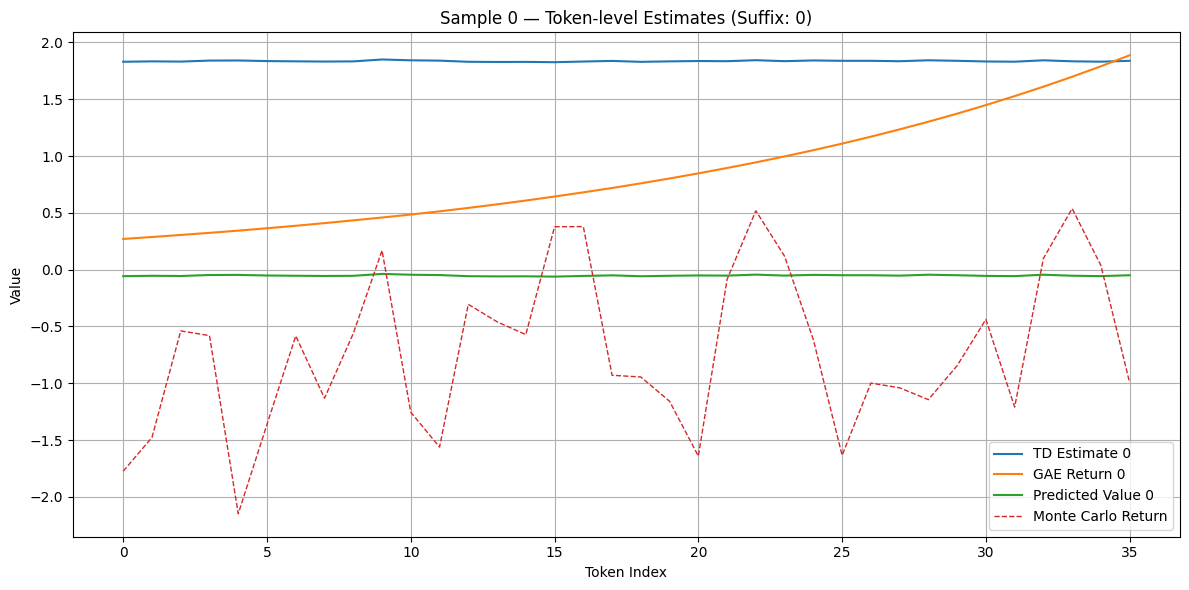

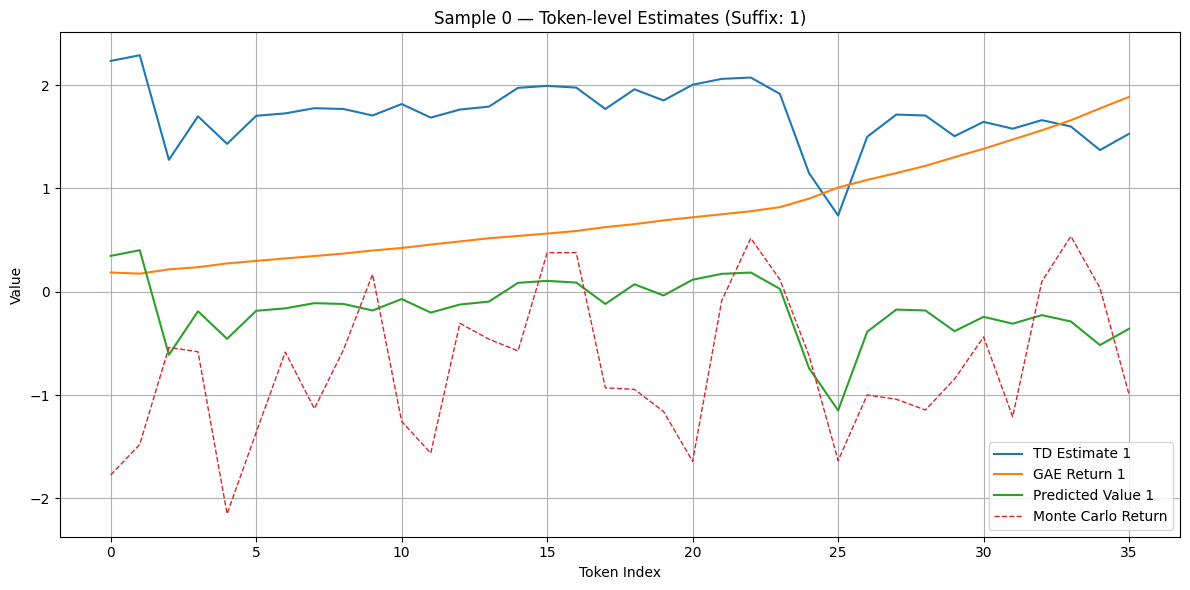

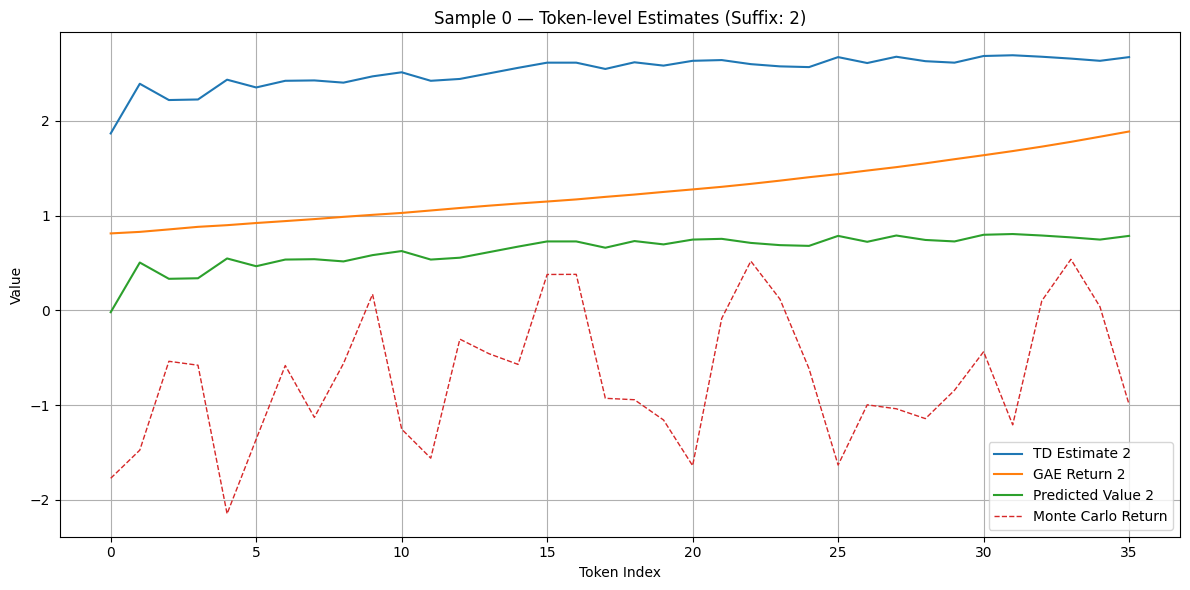

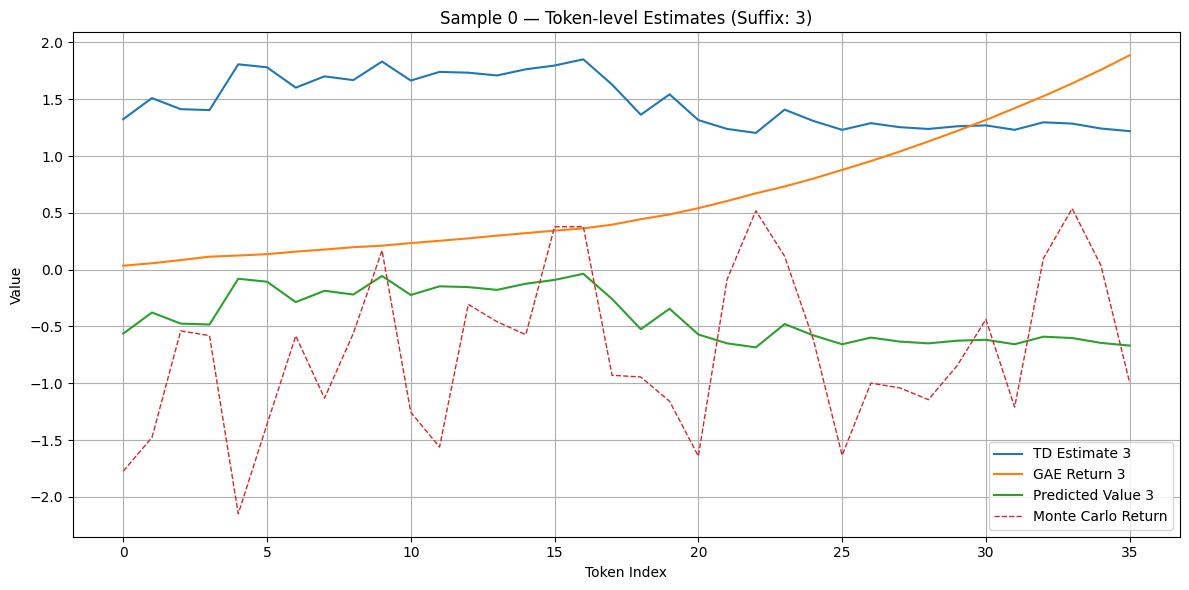

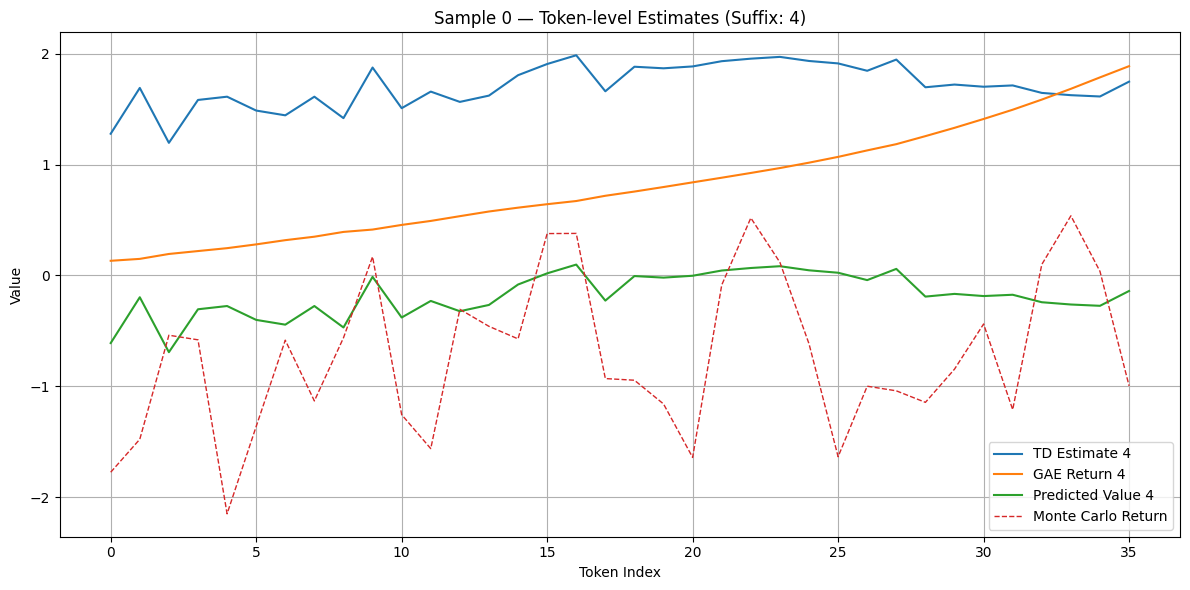

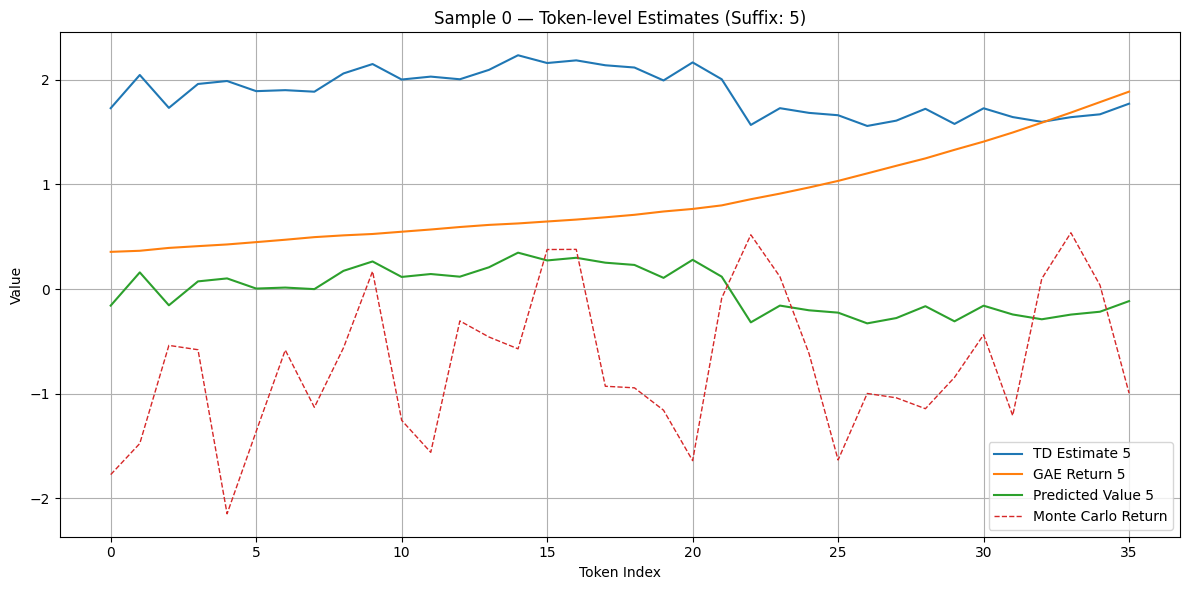

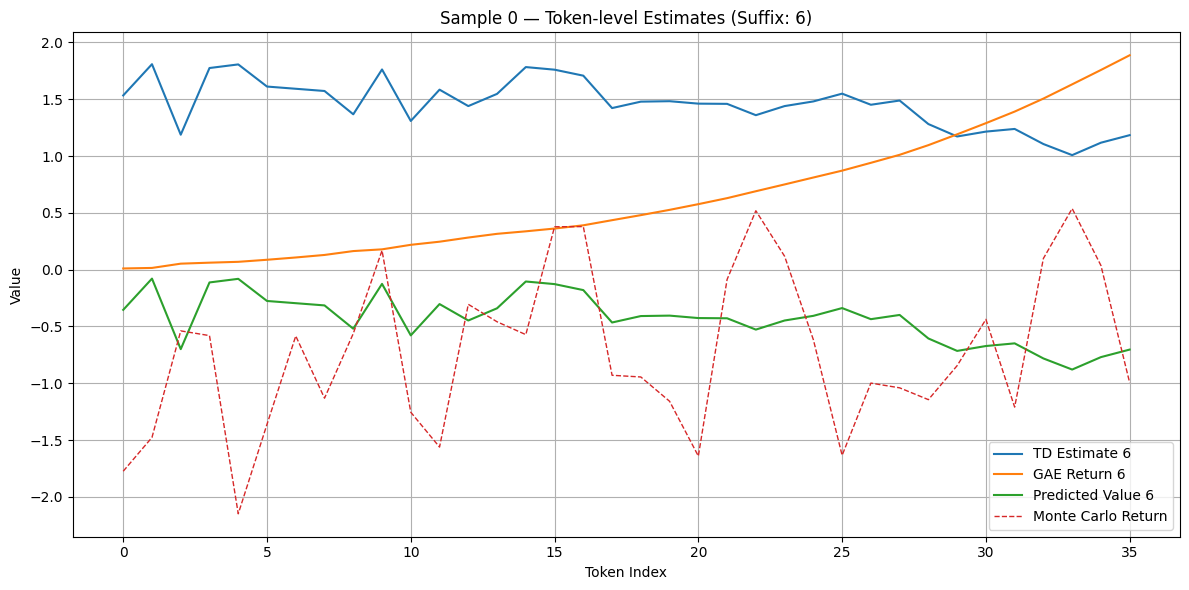

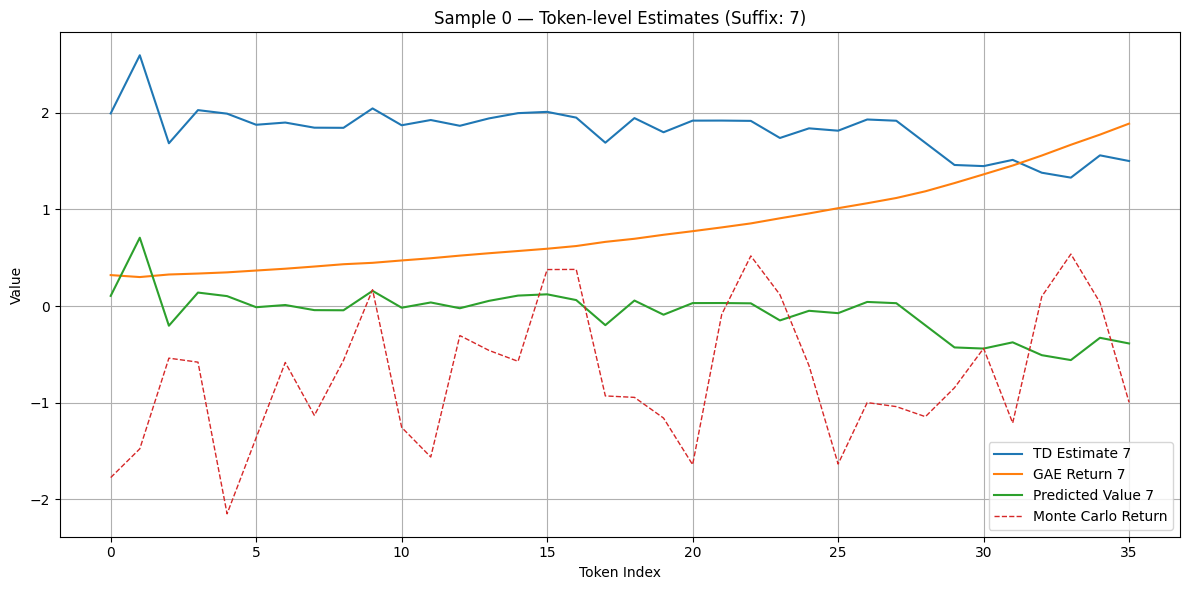

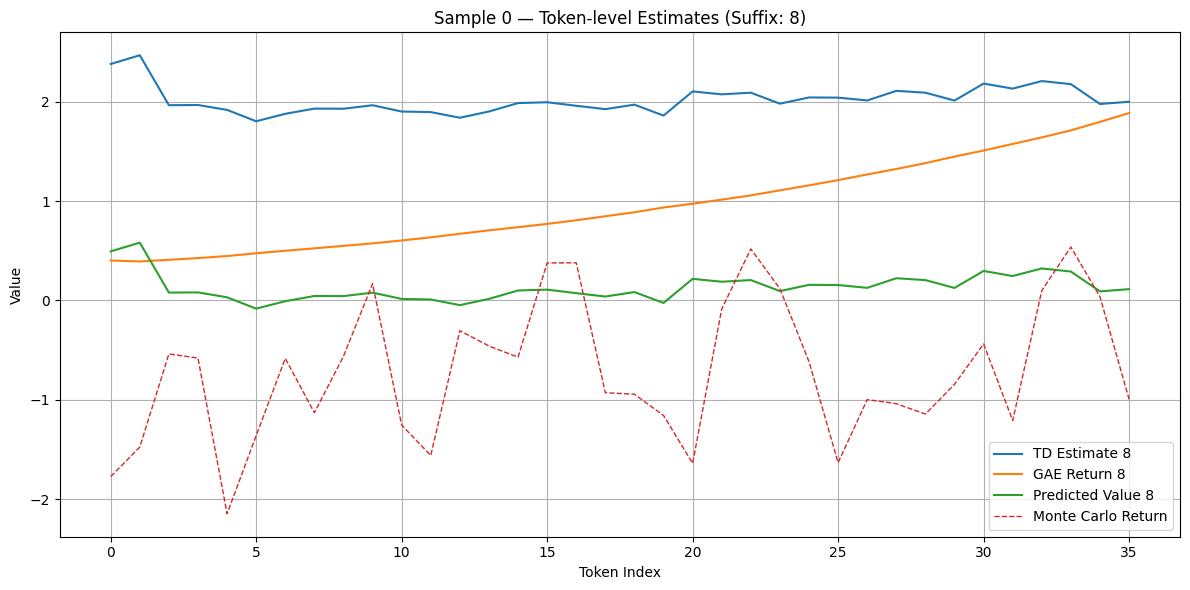

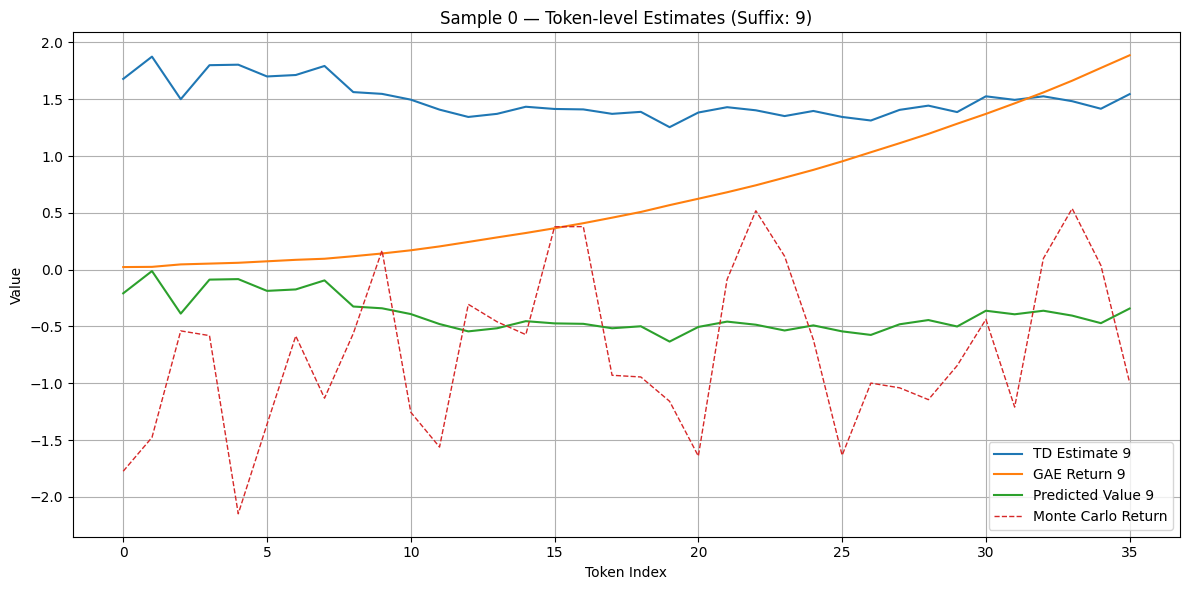

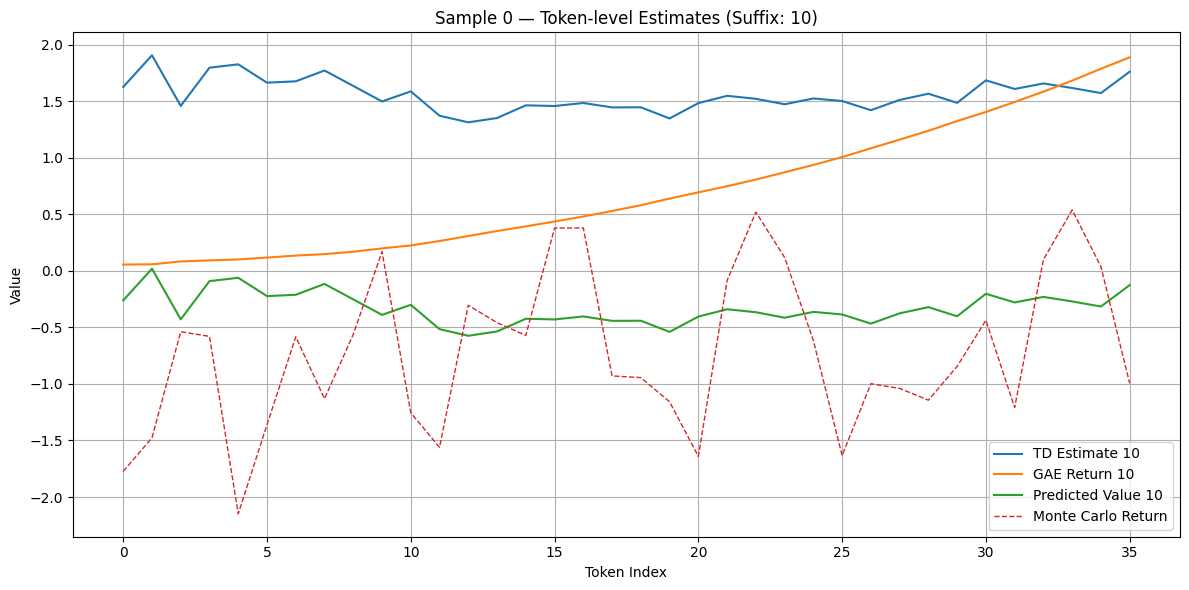

In [41]:
import matplotlib.pyplot as plt

# Choose the sample index
idx = 0
row = eval_df.iloc[idx]
seq_len = row["response_token_len"]
x = list(range(seq_len))

# Extract suffixes that exist for pred_value_per_token_<suffix>
suffixes = []
for col in eval_df.columns:
    if col.startswith("pred_value_per_token_"):
        suffix = col.split("pred_value_per_token_")[1]
        suffixes.append(suffix)

# Plot one figure per suffix
for suffix in suffixes:
    plt.figure(figsize=(12, 6))

    td = row.get(f"td_estimate_{suffix}", None)
    gae = row.get(f"gae_return_{suffix}", None)
    pred = row.get(f"pred_value_per_token_{suffix}", None)
    mc = row.get(f"mc_per_token_k9_temp2", None)  # ✅ Corrected line

    if td is not None:
        plt.plot(x, td, label=f"TD Estimate {suffix}")
    if gae is not None:
        plt.plot(x, gae, label=f"GAE Return {suffix}")
    if pred is not None:
        plt.plot(x, pred, label=f"Predicted Value {suffix}")
    if mc is not None:
        plt.plot(x, mc, label=f"Monte Carlo Return", linestyle="--", linewidth=1)

    plt.title(f"Sample {idx} — Token-level Estimates (Suffix: {suffix})")
    plt.xlabel("Token Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
